In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
#path that contains folder you want to copy
!cp -av "/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data" "Data"

'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data' -> 'Data/Data'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/ayam_goreng' -> 'Data/Data/ayam_goreng'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/ayam_goreng/ayam_goreng (1).jpg' -> 'Data/Data/ayam_goreng/ayam_goreng (1).jpg'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/ayam_goreng/ayam_goreng (10).jpg' -> 'Data/Data/ayam_goreng/ayam_goreng (10).jpg'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/ayam_goreng/ayam_goreng (107).jpg' -> 'Data/Data/ayam_goreng/ayam_goreng (107).jpg'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/ayam_goreng/ayam_goreng (101).jpg' -> 'Data/Data/ayam_goreng/ayam_goreng (101).jpg'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/ayam_goreng/ayam_goreng (128).JPG' -> 'Data/Data/ayam_goreng/ayam_goreng (128).JPG'
'/content/drive/MyDrive/CAPSTONE BANGKIT/Machine Learning/Data/ayam_goreng/ayam_goreng (1

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [70]:
image_dir = Path('/content/Data/Data')

In [71]:
filepaths = list(image_dir.glob(r'**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(203, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [73]:
image_df

,Filepath,Label
0,/content/Data/Data/telur_dadar/telur_dadar (20...,telur_dadar
1,/content/Data/Data/gulai_ikan/gulai_ikan (68).jpg,gulai_ikan
2,/content/Data/Data/gulai_ikan/gulai_ikan (69).jpg,gulai_ikan
3,/content/Data/Data/telur_dadar/telur_dadar (89...,telur_dadar
4,/content/Data/Data/telur_dadar/telur_dadar (19...,telur_dadar
...,...,...
1822,/content/Data/Data/gulai_ikan/gulai_ikan (129)...,gulai_ikan
1823,/content/Data/Data/gulai_tambusu/gulai_tambusu...,gulai_tambusu
1824,/content/Data/Data/gulai_tunjang/gulai_tunjang...,gulai_tunjang
1825,/content/Data/Data/telur_dadar/telur_dadar (17...,telur_dadar


In [74]:
image_df['Label'].value_counts()

telur_dadar        203
gulai_ikan         203
telur_balado       203
ayam_pop           203
daging_rendang     203
gulai_tambusu      203
dendeng_batokok    203
ayam_goreng        203
gulai_tunjang      203
Name: Label, dtype: int64

In [75]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [76]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [77]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1480 validated image filenames belonging to 9 classes.
Found 164 validated image filenames belonging to 9 classes.
Found 183 validated image filenames belonging to 9 classes.


In [78]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [79]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [80]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
47/47 [==============================] - 46s 835ms/step - loss: 1.2237 - accuracy: 0.6054 - val_loss: 0.7689 - val_accuracy: 0.7439
Epoch 2/100
47/47 [==============================] - 40s 856ms/step - loss: 0.5252 - accuracy: 0.8243 - val_loss: 0.6936 - val_accuracy: 0.7866
Epoch 3/100
47/47 [==============================] - 36s 764ms/step - loss: 0.4141 - accuracy: 0.8547 - val_loss: 0.5023 - val_accuracy: 0.8415
Epoch 4/100
47/47 [==============================] - 35s 752ms/step - loss: 0.3367 - accuracy: 0.8764 - val_loss: 0.4606 - val_accuracy: 0.8476
Epoch 5/100
47/47 [==============================] - 34s 718ms/step - loss: 0.2907 - accuracy: 0.9000 - val_loss: 0.4591 - val_accuracy: 0.8537
Epoch 6/100
47/47 [==============================] - 35s 751ms/step - loss: 0.2770 - accuracy: 0.9027 - val_loss: 0.6165 - val_accuracy: 0.7866
Epoch 7/100
47/47 [==============================] - 34s 726ms/step - loss: 0.2478 - accuracy: 0.9108 - val_loss: 0.5534 - val_accuracy:

In [81]:
results = model.evaluate(test_images, verbose=2)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

6/6 - 2s - loss: 0.4042 - accuracy: 0.8634 - 2s/epoch - 374ms/step
Test Accuracy: 86.34%


In [82]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

6/6 [==============================] - 2s 290ms/step


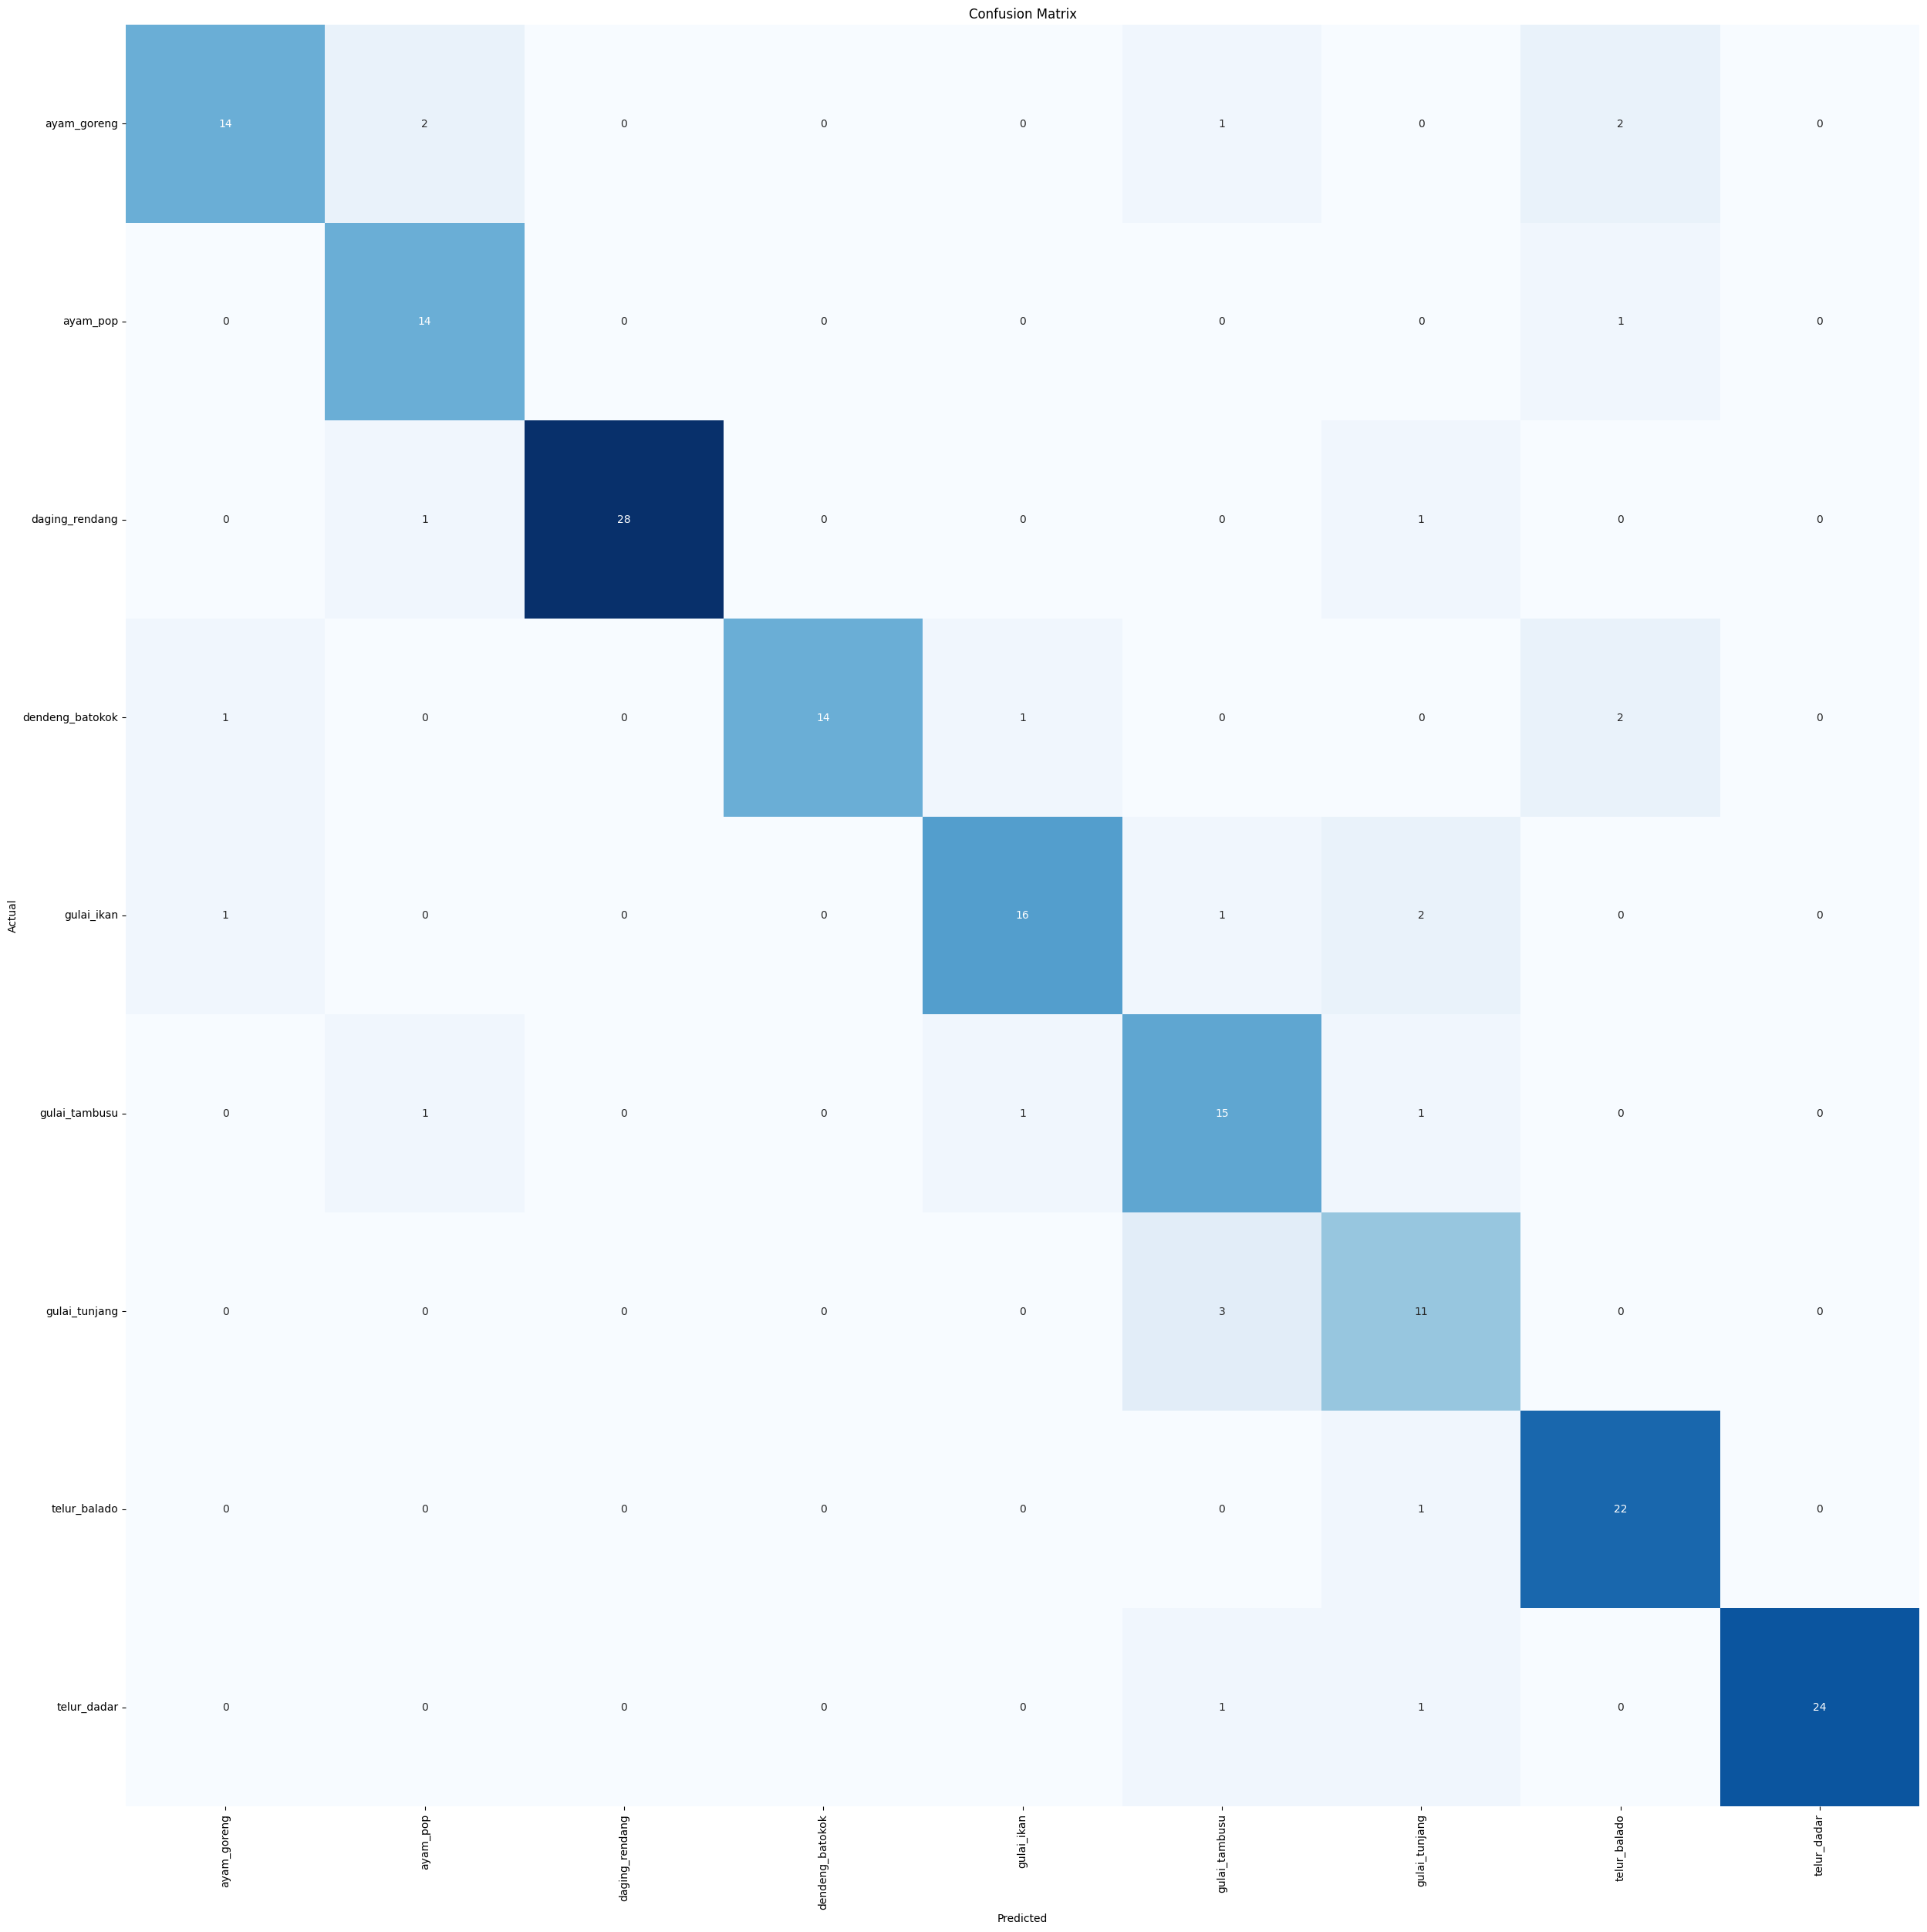

In [86]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(9) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

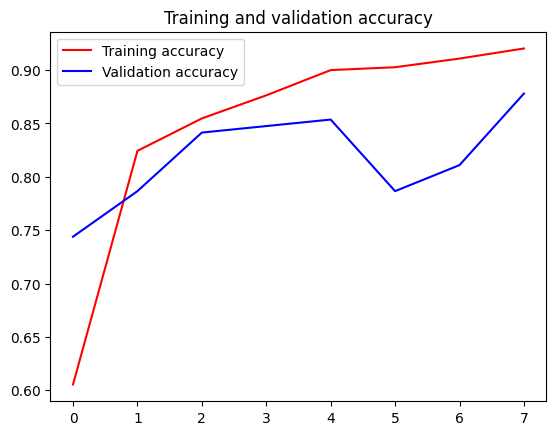

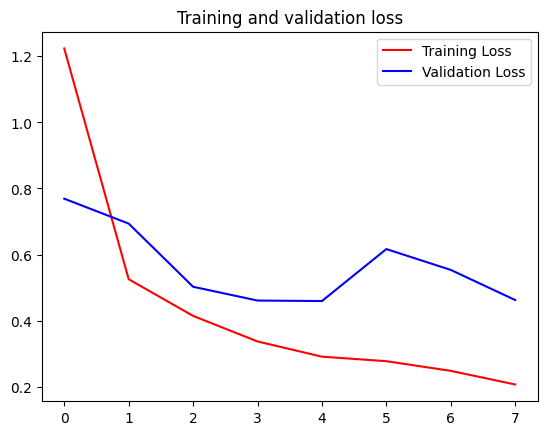

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [87]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                  precision    recall  f1-score   support

    ayam_goreng       0.88      0.74      0.80        19
       ayam_pop       0.78      0.93      0.85        15
 daging_rendang       1.00      0.93      0.97        30
dendeng_batokok       1.00      0.78      0.88        18
     gulai_ikan       0.89      0.80      0.84        20
  gulai_tambusu       0.71      0.83      0.77        18
  gulai_tunjang       0.65      0.79      0.71        14
   telur_balado       0.81      0.96      0.88        23
    telur_dadar       1.00      0.92      0.96        26

       accuracy                           0.86       183
      macro avg       0.86      0.85      0.85       183
   weighted avg       0.88      0.86      0.87       183



In [91]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

labels = ["Ayam goreng", "Ayam pop", "Daging Rendang", "Dendeng Batokok", "Gulai Ikan", "Gulai Tambusu", "Gulai Tunjang", "Telur balado", "Telur dadar"]

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=32)

    highest_score_index = np.argmax(classes)
    highest_score = classes[0][highest_score_index]
    highest_score_label = labels[highest_score_index]

    print(classes)
    print("Highest Score:", highest_score)
    print("Highest Score Label:", highest_score_label)


Saving rendang.jpg to rendang (4).jpg
1/1 [==============================] - 0s 23ms/step
[[0.0200271  0.03300438 0.82785136 0.01986178 0.03739145 0.01249146
  0.04166073 0.00679024 0.0009215 ]]
Highest Score: 0.82785136
Highest Score Label: Daging Rendang
